## Sparse Signal Recovery


WRITE STUFF HERE


$$
\underset{x}{\min} \quad \frac{1}{m} \sum_{i=1}^m|A_i x - b_i| + \lambda \sum_{j=1}^n |x_j|
$$
where $A_i$ is the $i$-th row of $A$.

The functions in the problem above are piecewise lienear, so we need to reformulate into a LP by introducing addition variables, $y$ and $z$.

\begin{align*}
\underset{x,y,z}{\min} \quad &\frac{1}{m}\sum_{i=1}^m y_i + \lambda \sum_{j=1}^n t_j \\
\text{s.t.} \quad \ \ &y_i \geq A_i x - b_i \ \forall i=1,\dots,m \\
&y_i \geq -(A_i x - b_i) \ \forall i=1,\dots,m \\
&t_j \geq x_j \ \forall j=1,\dots,n \\
&t_j \geq -x_j \ \forall j=1,\dots,n
\end{align*}

In [51]:
using JuMP
using HiGHS
using Random, Distributions
using LinearAlgebra

#Make sure notebook always produces the same results
Random.seed!(0)

n=100;
m=1000;

numsamples = m;

#Create a Cauchy distribution with parameters 0 and 1
#Well known symmetric, heavy-tailed distribution, see, e.g. https://en.wikipedia.org/wiki/Cauchy_distribution for details.
d = Cauchy(0, 1)

#Generate a random vector using uniformly at random noise,
#just going to be used to select some indices which will
#be non-zero in our "ground truth" vector
v = rand(Uniform(0,1), 100)
#Find the 10 indices with the largest values in v
nonzeros = partialsortperm(v, 1:10)

#Create a vector of 0's
groundtruth = zeros(n)
#For the indices that will be non-zero, give them a random value
for i=1:length(nonzeros)
    groundtruth[nonzeros[i]] = rand(Normal(0,5))
end

#Create a random matrix using the matrix normal distribution
A = rand(MatrixNormal(zeros(m,n), Diagonal(ones(m,m)), Diagonal(ones(n,n))))

#Set the RHS vector be to be A*groundtruth + noise
#(coming from the distribution d) defined above
b = A*groundtruth + rand(d, m)

#Run this with no regularization, regularization parameter of 2 and
#regularization parameter of 5
lambdas = [0, .005, .025]

xout = zeros(n,length(lambdas))

i = 1
#Run this loop once per regularization parameter λ
#Store the result in a column of xout
for λ in lambdas
    sparse = Model(HiGHS.Optimizer)
    @variable(sparse, x[1:n])
    #Add epigraph variables
    @variable(sparse, y[1:n] >= 0)
    @variable(sparse, t[1:n] >= 0)

    #Add epigraph constraints for the absolute value of x
    @constraint(sparse, epigraph1y[i in 1:n], y[i] >= sum(A[i,j]*x[j] for j in 1:n)-b[i])
    @constraint(sparse, epigraph2y[i in 1:n], y[i] >= -(sum(A[i,j]*x[j] for j in 1:n)-b[i]))

    @constraint(sparse, epigraph1t[i in 1:n], t[i] >= x[i])
    @constraint(sparse, epigraph2t[i in 1:n], t[i] >= -x[i])

    #Objective is least squares + λ*\|x\|_1 (which is handled by the epigraph constraints)
    @objective(sparse, Min, (1/m)*sum(y[i] for i in 1:n) + λ*sum(t[i] for i in 1:n))

    optimize!(sparse);
    xout[:,i] = value.(x)
    i = i+1
end

Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
200 rows, 200 cols, 20200 nonzeros
200 rows, 200 cols, 20200 nonzeros
Presolve : Reductions: rows 200(-200); columns 200(-100); elements 20200(-400)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 100(694.209); Du: 0(3.22226e-09) 0s
        100     0.0000000000e+00 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 100
Objective value     :  0.0000000000e+00
HiGHS run time      :          0.01
Running HiGHS 1.6.0: Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
400 rows, 300 cols, 20600 nonzeros
400 rows, 300 cols, 20600 nonzeros
Presolve : Reductions: rows 400(-0); columns 300(-0); elements 20600(-0) - Not reduced
Problem not reduced by presolve: solving the LP
Using EKK dual simplex solver - serial
  I

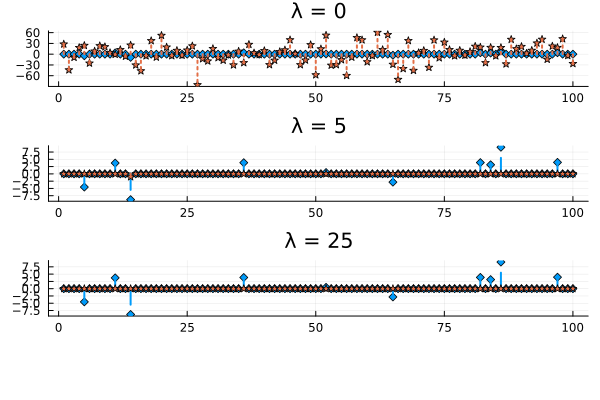

In [52]:
xaxis = 1:n

using Plots

#Plot the results for different values of λ
#Blue diamonds are the "ground truth", red stars are the solution for that lambda parameter
plot1 = plot(xaxis, groundtruth, seriestype = :sticks, markershape = :diamond, linewidth = 2, markerwidth = 5, linestyle = :dash, title = "λ = 0")
plot1 = plot!(xaxis, xout[:,1], seriestype = :sticks, markershape = :star5, linewidth = 2, markerwidth = 5, linestyle = :dot)

plot2 = plot(xaxis, groundtruth, seriestype = :sticks,markershape = :diamond, linewidth = 2, markerwidth = 5, linestyle = :dash, title = "λ = 5")
plot2 = plot!(xaxis, xout[:,2], seriestype = :sticks, markershape = :star5, linewidth = 2, markerwidth = 5, linestyle = :dot)

plot3 = plot(xaxis, groundtruth, seriestype = :sticks,markershape = :diamond, linewidth = 2, markerwidth = 5, linestyle = :dash, title = "λ = 25")
plot3 = plot!(xaxis, xout[:,3], seriestype = :sticks, markershape = :star5, linewidth = 2, markerwidth = 5, linestyle = :dot)

plot(plot1, plot2, plot3, layout = (4, 1), legend = false)